## Table of Contents

<ol>
    <li>
        <a href="#Introduction">Introduction</a>
    </li>
    <li>
        <a href="#Preparing-the-data">Preparing the data</a>
    </li>
    <li>
        <a href="#Fine-tuning-the-model-with-the-Trainer-API">Fine-tuning the model with the Trainer API</a>
    </li>
    <li>
        <a href="#Using-the-fine-tuned model">Training loop</a>
    </li>
    <li>
        <a href="#A-custom-training-loop">A custom training loop</a>
    </li>
    <li>
        <a href="#Training-loop">Training loop</a>
    </li>
</ol>

## Introduction

Time to look at question answering! This task comes in many flavors, but the one we’ll focus on in this section is called extractive question answering. This involves posing questions about a document and identifying the answers as spans of text in the document itself.

We will fine-tune a BERT model on the [SQuAD dataset](https://rajpurkar.github.io/SQuAD-explorer/), which consists of questions posed by crowdworkers on a set of Wikipedia articles. This will give us a model able to compute predictions like this one:

This is actually showcasing the model that was trained and uploaded to the Hub using the code shown in this section. You can find it and double-check the predictions [here](https://huggingface.co/huggingface-course/bert-finetuned-squad?context=%F0%9F%A4%97+Transformers+is+backed+by+the+three+most+popular+deep+learning+libraries+%E2%80%94+Jax%2C+PyTorch+and+TensorFlow+%E2%80%94+with+a+seamless+integration+between+them.+It%27s+straightforward+to+train+your+models+with+one+before+loading+them+for+inference+with+the+other.&question=Which+deep+learning+libraries+back+%F0%9F%A4%97+Transformers%3F).

💡 Encoder-only models like BERT tend to be great at extracting answers to factoid questions like “Who invented the Transformer architecture?” but fare poorly when given open-ended questions like “Why is the sky blue?” In these more challenging cases, encoder-decoder models like T5 and BART are typically used to synthesize the information in a way that’s quite similar to [text summarization](https://huggingface.co/course/chapter7/5). If you’re interested in this type of generative question answering, we recommend checking out our [demo](https://yjernite.github.io/lfqa.html) based on the [ELI5 dataset](https://huggingface.co/datasets/eli5).

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
Tesla P40


## Preparing the data

The dataset that is used the most as an academic benchmark for extractive question answering is [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/), so that’s the one we’ll use here. There is also a harder [SQuAD v2](https://huggingface.co/datasets/squad_v2) benchmark, which includes questions that don’t have an answer. As long as your own dataset contains a column for contexts, a column for questions, and a column for answers, you should be able to adapt the steps below.

###  The SQuAD dataset
As usual, we can download and cache the dataset in just one step thanks to `load_dataset()`:

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("squad")

We can then have a look at this object to learn more about the SQuAD dataset:

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

It looks like we have everything we need with the context, question, and answers fields, so let’s print those for the first element of our training set:

In [4]:
print("Context: ", raw_datasets["train"][0]["context"],"\n")
print("Question: ", raw_datasets["train"][0]["question"],"\n")
print("Answer: ", raw_datasets["train"][0]["answers"],"\n")

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. 

Question:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? 

Answer:  {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]} 



The `context` and `question` fields are very straightforward to use. The `answers` field is a bit trickier as it comports a dictionary with two fields that are both lists. This is the format that will be expected by the `squad` metric during evaluation; if you are using your own data, you don’t necessarily need to worry about putting the answers in the same format. The `text` field is rather obvious, and the `answer_start` field contains the starting character index of each answer in the context.

During training, there is only one possible answer. We can double-check this by using the `Dataset.filter()` method:

In [5]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

For evaluation, however, there are several possible answers for each sample, which may be the same or different:

In [6]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


We won’t dive into the evaluation script as it will all be wrapped up by a 🤗 Datasets metric for us, but the short version is that some of the questions have several possible answers, and this script will compare a predicted answer to all the acceptable answers and take the best score. If we take a look at the sample at index 2, for instance:

In [7]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Where did Super Bowl 50 take place?


we can see that the answer can indeed be one of the three possibilities we saw before.

###  Processing the training data

Let’s start with preprocessing the training data. The hard part will be to generate labels for the question’s answer, which will be the start and end positions of the tokens corresponding to the answer inside the context.

But let’s not get ahead of ourselves. First, we need to convert the text in the input into IDs the model can make sense of, using a tokenizer:

In [8]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


As mentioned previously, we’ll be fine-tuning a BERT model, but you can use any other model type as long as it has a fast tokenizer implemented. You can see all the architectures that come with a fast version in this big table, and to check that the `tokenizer` object you’re using is indeed backed by 🤗 Tokenizers you can look at its `is_fast` attribute:

```
tokenizer.is_fast
>>> True
```

We can pass to our tokenizer the question and the context together, and it will properly insert the special tokens to form a sentence like this:

```
[CLS] question [SEP] context [SEP]
```

Let’s double-check:

In [9]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

print(question, context)
print()

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.



'[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

The labels will then be the index of the tokens starting and ending the answer, and the model will be tasked to predicted one start and end logit per token in the input, with the theoretical labels being as follow:

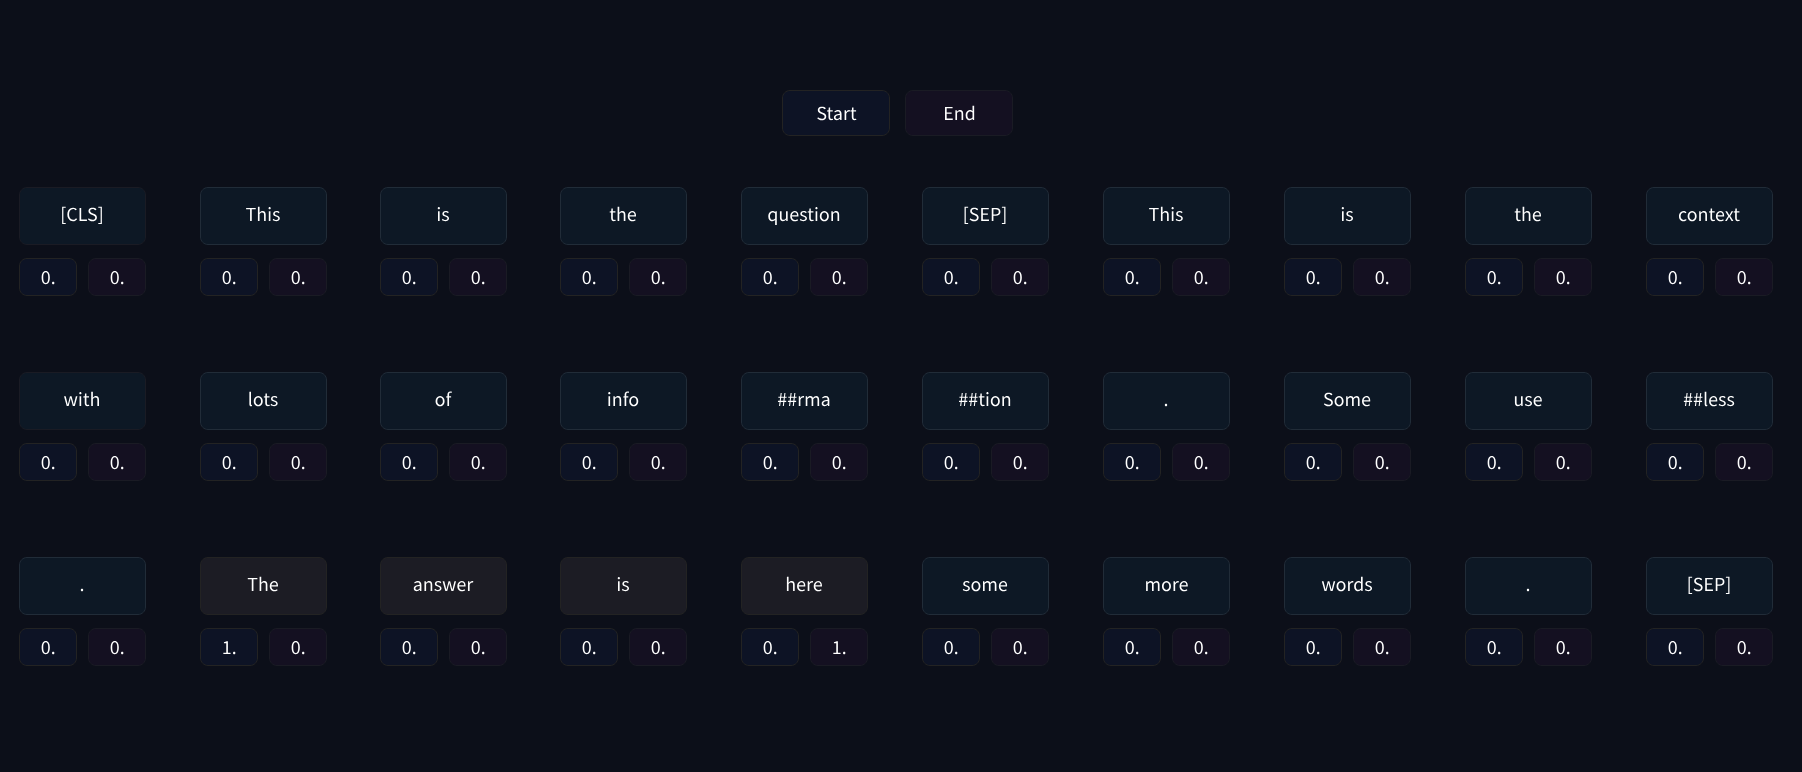

In this case the context is not too long, but some of the examples in the dataset have very long contexts that will exceed the maximum length we set (which is 384 in this case). As we saw in [Chapter 6](https://huggingface.co/course/chapter6/4) when we explored the internals of the `question-answering` pipeline, we will deal with long contexts by creating several training features from one sample of our dataset, with a sliding window between them.

To see how this works using the current example, we can limit the length to 100 and use a sliding window of 50 tokens. As a reminder, we use:

- `max_length` to set the maximum length (here 100)

- `truncation="only_second"` to truncate the context (which is in the second position) when the question with its context is too long

- `stride` to set the number of overlapping tokens between two successive chunks (here 50)

- `return_overflowing_tokens=True` to let the tokenizer know we want the overflowing tokens

In [10]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))
    print("---")

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]
---
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]
---
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building 

As we can see, our example has been in split into four inputs, each of them containing the question and some part of the context. Note that the answer to the question (“Bernadette Soubirous”) only appears in the third and last inputs, so by dealing with long contexts in this way we will create some training examples where the answer is not included in the context. For those examples, the labels will be `start_position = end_position = 0` (so we predict the [CLS] token). We will also set those labels in the unfortunate case where the answer has been truncated so that we only have the start (or end) of it. For the examples where the answer is fully in the context, the labels will be the index of the token where the answer starts and the index of the token where the answer ends.


The dataset provides us with the start character of the answer in the context, and by adding the length of the answer, we can find the end character in the context. To map those to token indices, we will need to use the offset mappings we studied in [Chapter 6](https://huggingface.co/course/chapter6/4). We can have our tokenizer return these by passing along `return_offsets_mapping=True`:

In [11]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

As we can see, we get back the usual input IDs, token type IDs, and attention mask, as well as the offset mapping we required and an extra key, overflow_to_sample_mapping. The corresponding value will be of use to us when we tokenize several texts at the same time (which we should do to benefit from the fact that our tokenizer is backed by Rust). Since one sample can give several features, it maps each feature to the example it originated from. Because here we only tokenized one example, we get a list of 0s:



In [12]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0]

But if we tokenize more examples, this will become more useful:

In [13]:
# Tokenizing a subset of the training dataset (from index 2 to 5)
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],  # Extracting 'question' field for tokenization
    raw_datasets["train"][2:6]["context"],   # Extracting 'context' field for tokenization
    max_length=100,                          # Setting maximum sequence length to 100 tokens
    truncation="only_second",                # Truncating the 'context' part if it exceeds max_length
    stride=50,                               # Stride size of 50 tokens for handling overflow (splitting into multiple chunks)
    return_overflowing_tokens=True,          # Ensuring that any overflow tokens are returned
    return_offsets_mapping=True,             # Returning offset mappings to trace original positions of tokens
)

# Printing the total number of tokenized sequences generated
print(f"The 4 examples gave {len(inputs['input_ids'])} features.")

# Printing the mapping from overflowed tokens back to the original dataset entries
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")


The 4 examples gave 19 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


As we can see, the first three examples (at indices 2, 3, and 4 in the training set) each gave four features and the last example (at index 5 in the training set) gave 7 features.

This information will be useful to map each feature we get to its corresponding label. As mentioned earlier, those labels are:

- `(0, 0)` if the answer is not in the corresponding span of the context

- `(start_position, end_position)` if the answer is in the corresponding span of the context, with `start_position` being the index of the token (in the input IDs) at the start of the answer and `end_position` being the index of the token (in the input IDs) where the answer ends

To determine which of these is the case and, if relevant, the positions of the tokens, we first find the indices that start and end the context in the input IDs. We could use the token type IDs to do this, but since those do not necessarily exist for all models (DistilBERT does not require them, for instance), we’ll instead use the `sequence_ids()` method of the `BatchEncoding` our tokenizer returns.

Once we have those token indices, we look at the corresponding offsets, which are tuples of two integers representing the span of characters inside the original context. We can thus detect if the chunk of the context in this feature starts after the answer or ends before the answer begins (in which case the label is `(0, 0)`). If that’s not the case, we loop to find the first and last token of the answer:

In [14]:
# Extracting the "answers" from the raw dataset (train subset)
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []  # List to store start token positions
end_positions = []  # List to store end token positions

# Iterate through the input sequence offsets
for i, offset in enumerate(inputs["offset_mapping"]):
    # Mapping index from the overflow sequence
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    
    # Get the starting character and the ending character of the answer
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    
    # Get the sequence IDs to identify the context and question spans
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context (part of the input that holds the passage)
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx  # First token of the context
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1  # Last token of the context

    # If the answer is not fully inside the context (not in the context span), label the positions as (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise, find the token positions corresponding to the answer's start and end within the context
        idx = context_start
        # Find the token corresponding to the start of the answer
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)  # Append the start token position

        idx = context_end
        # Find the token corresponding to the end of the answer
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)  # Append the end token position

# Return the final start and end positions
start_positions, end_positions


([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],
 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

Let’s take a look at a few results to verify that our approach is correct. For the first feature we find `(83, 85)` as labels, so let’s compare the theoretical answer with the decoded span of tokens from 83 to 85 (inclusive):

In [15]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
print(start, end)
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

83 85
Theoretical answer: the Main Building, labels give: the Main Building


In [16]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3]

So that’s a match! Now let’s check index 4, where we set the labels to `(0, 0)`, which means the answer is not in the context chunk of that feature:

In [17]:
idx = 4
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: a Marian place of prayer and reflection, decoded example: [CLS] What is the Grotto at Notre Dame? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grot [SEP]


Indeed, we don’t see the answer inside the context.

✏️ Your turn! When using the `XLNet architecture`, padding is applied on the left and the question and context are switched. Adapt all the code we just saw to the XLNet architecture (and add `padding=True`). Be aware that the `[CLS]` token may not be at the 0 position with padding applied.

Now that we have seen step by step how to preprocess our training data, we can group it in a function we will apply on the whole training dataset. We’ll pad every feature to the maximum length we set, as most of the contexts will be long (and the corresponding samples will be split into several features), so there is no real benefit to applying dynamic padding here:

In [18]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Note that we defined two constants to determine the maximum length used as well as the length of the sliding window, and that we added a tiny bit of cleanup before tokenizing: some of the questions in the SQuAD dataset have extra spaces at the beginning and the end that don’t add anything (and take up space when being tokenized if you use a model like RoBERTa), so we removed those extra spaces.

To apply this function to the whole training set, we use the `Dataset.map()` method with the `batched=True` flag. It’s necessary here as we are changing the length of the dataset (since one example can give several training features):

In [19]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

(87599, 88729)

As we can see, the preprocessing added roughly 1,000 features. Our training set is now ready to be used — let’s dig into the preprocessing of the validation set!

##  Processing the validation data

Preprocessing the validation data will be slightly easier as we don’t need to generate labels (unless we want to compute a validation loss, but that number won’t really help us understand how good the model is). The real joy will be to interpret the predictions of the model into spans of the original context. For this, we will just need to store both the offset mappings and some way to match each created feature to the original example it comes from. Since there is an ID column in the original dataset, we’ll use that ID.

The only thing we’ll add here is a tiny bit of cleanup of the offset mappings. They will contain offsets for the question and the context, but once we’re in the post-processing stage we won’t have any way to know which part of the input IDs corresponded to the context and which part was the question (the `sequence_ids()` method we used is available for the output of the tokenizer only). So, we’ll set the offsets corresponding to the question to `None`:

In [20]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

We can apply this function on the whole validation dataset like before:

In [21]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

(10570, 10822)

In this case we’ve only added a couple of hundred samples, so it appears the contexts in the validation dataset are a bit shorter.

Now that we have preprocessed all the data, we can get to the training.

In [22]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 88729
})

In [23]:
validation_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 10822
})

## Fine-tuning the model with the Trainer API

The training code for this example will look a lot like the code in the previous sections — the hardest thing will be to write the `compute_metrics()` function. Since we padded all the samples to the maximum length we set, there is no data collator to define, so this metric computation is really the only thing we have to worry about. The difficult part will be to post-process the model predictions into spans of text in the original examples; once we have done that, the metric from the 🤗 Datasets library will do most of the work for us.

###  Post-processing

The model will output logits for the start and end positions of the answer in the input IDs, as we saw during our exploration of the [question-answering pipeline](https://huggingface.co/course/chapter6/3b). The post-processing step will be similar to what we did there, so here’s a quick reminder of the actions we took:

- We masked the start and end logits corresponding to tokens outside of the context.
- We then converted the start and end logits into probabilities using a softmax.
- We attributed a score to each `(start_token, end_token)` pair by taking the product of the corresponding two probabilities.
- We looked for the pair with the maximum score that yielded a valid answer (e.g., a `start_token` lower than `end_token`).

Here we will change this process slightly because we don’t need to compute actual scores (just the predicted answer). This means we can skip the softmax step. To go faster, we also won’t score all the possible (start_token, end_token) pairs, but only the ones corresponding to the highest `n_best` logits (with `n_best=20`). Since we will skip the softmax, those scores will be logit scores, and will be obtained by taking the sum of the start and end logits (instead of the product, because of the $rulelog⁡(ab)=log⁡(a)+log⁡(b)$.

To demonstrate all of this, we will need some kind of predictions. Since we have not trained our model yet, we are going to use the default model for the QA pipeline to generate some predictions on a small part of the validation set. We can use the same processing function as before; because it relies on the global constant `tokenizer`, we just have to change that object to the tokenizer of the model we want to use temporarily:

In [24]:
small_eval_set = raw_datasets["validation"].select(range(100))

trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)

eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

eval_set

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 100
})

Now that the preprocessing is done, we change the tokenizer back to the one we originally picked:

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

We then remove the columns of our `eval_set` that are not expected by the model, build a batch with all of that small validation set, and pass it through the model. If a GPU is available, we use it to go faster:

In [26]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}

trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

Since the `Trainer` will give us predictions as `NumPy` arrays, we grab the start and end logits and convert them to that format:

In [27]:
start_logits = outputs.start_logits.cpu().numpy()

end_logits = outputs.end_logits.cpu().numpy()

Now, we need to find the predicted answer for each example in our `small_eval_set`. One example may have been split into several features in `eval_set`, so the first step is to map each example in `small_eval_set` to the corresponding features in `eval_set`:


In [28]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the `n_best` start logits and end logits, excluding positions that give:

- An answer that wouldn’t be inside the context

- An answer with negative length

- An answer that is too long (we limit the possibilities at `max_answer_length=30`)

Once we have all the scored possible answers for one example, we just pick the one with the best logit score:

In [29]:
import numpy as np

# Set the number of best answers to consider and the maximum allowed answer length
n_best = 20
max_answer_length = 30

# List to store the predicted answers for each example
predicted_answers = []

# Iterate through each example in the evaluation set
for example in small_eval_set:
    example_id = example["id"]  # Get the example ID
    context = example["context"]  # Get the context (passage of text)
    answers = []  # List to store possible answers for this example

    # Iterate through the features (generated from the example) to get start and end logits
    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]  # Get start logits for this feature
        end_logit = end_logits[feature_index]  # Get end logits for this feature
        offsets = eval_set["offset_mapping"][feature_index]  # Get the offsets for the feature

        # Get the top n_best start and end indices based on logits
        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()

        # Iterate through the top start and end indices
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers that have a length < 0 or > max_answer_length
                if (
                    end_index < start_index  # End index must be greater than or equal to start index
                    or end_index - start_index + 1 > max_answer_length  # Answer length must be within limits
                ):
                    continue

                # Append the valid answer (text from context) and its logit score to the answers list
                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],  # Extract answer text
                        "logit_score": start_logit[start_index] + end_logit[end_index],  # Combine start and end logits as score
                    }
                )

    # Select the answer with the highest logit score as the best answer for this example
    best_answer = max(answers, key=lambda x: x["logit_score"])
    
    # Append the example ID and the best answer to the predicted answers list
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})


The final format of the predicted answers is the one that will be expected by the metric we will use. As usual, we can load it with the help of the 🤗 Evaluate library:

In [30]:
import evaluate

metric = evaluate.load("squad")

This metric expects the predicted answers in the format we saw above (a list of dictionaries with one key for the ID of the example and one key for the predicted text) and the theoretical answers in the format below (a list of dictionaries with one key for the ID of the example and one key for the possible answers):

In [31]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

We can now check that we get sensible results by looking at the first element of both lists:

In [32]:
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}


Not too bad! Now let’s have a look at the score the metric gives us:

In [33]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 83.0, 'f1': 88.25000000000004}

Again, that’s rather good considering that according to [its paper](https://arxiv.org/abs/1910.01108v2) DistilBERT fine-tuned on SQuAD obtains 79.1 and 86.9 for those scores on the whole dataset.

Now let’s put everything we just did in a `compute_metrics()` function that we will use in the `Trainer`. Normally, that `compute_metrics()` function only receives a tuple `eval_preds` with logits and labels. Here we will need a bit more, as we have to look in the dataset of features for the offset and in the dataset of examples for the original contexts, so we won’t be able to use this function to get regular evaluation results during training. We will only use it at the end of training to check the results.

The `compute_metrics()` function groups the same steps as before; we just add a small check in case we don’t come up with any valid answers (in which case we predict an empty string).

In [34]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

We can check it works on our predictions:

In [35]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 83.0, 'f1': 88.25000000000004}

Looking good! Now let’s use this to fine-tune our model.

###  Fine-tuning the model

We are now ready to train our model. Let’s create it first, using the `AutoModelForQuestionAnswering` class like before:

In [36]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


As usual, we get a warning that some weights are not used (the ones from the pretraining head) and some others are initialized randomly (the ones for the question answering head). You should be used to this by now, but that means this model is not ready to be used just yet and needs fine-tuning — good thing we’re about to do that!

To be able to push our model to the Hub, we’ll need to log in to Hugging Face. If you’re running this code in a notebook, you can do so with the following utility function, which displays a widget where you can enter your login credentials:

```python
from huggingface_hub import notebook_login

notebook_login()
```

If you aren’t working in a notebook, just type the following line in your terminal: `huggingface-cli login`

Once this is done, we can define our `TrainingArguments`. As we said when we defined our function to compute the metric, we won’t be able to have a regular evaluation loop because of the signature of the `compute_metrics()` function. We could write our own subclass of `Trainer` to do this (an approach you can find in the [question answering example script](https://github.com/huggingface/transformers/blob/master/examples/pytorch/question-answering/trainer_qa.py)), but that’s a bit too long for this section. Instead, we will only evaluate the model at the end of training here and show you how to do a regular evaluation in “A custom training loop” below.

This is really where the `Trainer` API shows its limits and the 🤗 Accelerate library shines: customizing the class to a specific use case can be painful, but tweaking a fully exposed training loop is easy.

Let’s take a look at our `TrainingArguments`:

In [37]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    fp16=True,
    # push_to_hub=True,
)

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cite a small training set and evaluation set

In [38]:
f = 0.1

# Shuffle and select the first f% of the rows
small_train_dataset = train_dataset.shuffle().select(range(int(f * train_dataset.num_rows)))

small_validation_dataset = validation_dataset.shuffle().select(range(int(f * validation_dataset.num_rows)))


In [39]:
small_train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 8872
})

In [40]:
small_validation_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 1082
})

We’ve seen most of these before: we set some hyperparameters (like the learning rate, the number of epochs we train for, and some weight decay) and indicate that we want to save the model at the end of every epoch, skip evaluation, and upload our results to the Model Hub. We also enable mixed-precision training with `fp16=True`, as it can speed up the training nicely on a recent GPU.

By default, the repository used will be in your namespace and named after the output directory you set, so in our case it will be in `"sgugger/bert-finetuned-squad"`. We can override this by passing a `hub_model_id`; for instance, to push the model to the `huggingface_course` organization we used `hub_model_id="huggingface_course/bert-finetuned-squad"` (which is the model we linked to at the beginning of this section).

💡 If the output directory you are using exists, it needs to be a local clone of the repository you want to push to (so set a new name if you get an error when defining your `Trainer`).

Finally, we just pass everything to the `Trainer` class and launch the training:

In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=small_train_dataset,
    eval_dataset=small_validation_dataset,
    tokenizer=tokenizer,
)

In [42]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=417, training_loss=2.096389587548711, metrics={'train_runtime': 3150.7382, 'train_samples_per_second': 8.448, 'train_steps_per_second': 0.132, 'total_flos': 5216005857964032.0, 'train_loss': 2.096389587548711, 'epoch': 3.0})

Note that while the training happens, each time the model is saved (here, every epoch) it is uploaded to the Hub in the background. This way, you will be able to to resume your training on another machine if necessary. The whole training takes a while (a little over an hour on a Titan RTX), so you can grab a coffee or reread some of the parts of the course that you’ve found more challenging while it proceeds. Also note that as soon as the first epoch is finished, you will see some weights uploaded to the Hub and you can start playing with your model on its page.

Once the training is complete, we can finally evaluate our model (and pray we didn’t spend all that compute time on nothing). The `predict()` method of the `Trainer` will return a tuple where the first elements will be the predictions of the model (here a pair with the start and end logits). We send this to our `compute_metrics()`function:

In [43]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 63.34910122989593, 'f1': 74.16305789984753}

Great! As a comparison, the baseline scores reported in the BERT article for this model are 80.8 and 88.5, so we’re right where we should be.

Finally, we use the `push_to_hub()` method to make sure we upload the latest version of the model:

```python
trainer.push_to_hub(commit_message="Training complete")
```

This returns the URL of the commit it just did, if you want to inspect it:

```
'https://huggingface.co/sgugger/bert-finetuned-squad/commit/9dcee1fbc25946a6ed4bb32efb1bd71d5fa90b68'
```

The `Trainer` also drafts a model card with all the evaluation results and uploads it.

At this stage, you can use the inference widget on the Model Hub to test the model and share it with your friends, family, and favorite pets. You have successfully fine-tuned a model on a question answering task — congratulations!

✏️ Your turn! Try another model architecture to see if it performs better on this task!

##  Using the fine-tuned model

We’ve already shown you how you can use the model we fine-tuned on the Model Hub with the inference widget. To use it locally in a `pipeline`, you just have to specify the model identifier:

In [48]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "bert-finetuned-squad/checkpoint-417"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'score': 0.40507030487060547, 'start': 33, 'end': 38, 'answer': 'three'}

Great! Our model is working as well as the default one for this pipeline!

If you want to dive a bit more deeply into the training loop, we will now show you how to do the same thing using 🤗 Accelerate.

##  A custom training loop

Let’s now have a look at the full training loop, so you can easily customize the parts you need. It will look a lot like the training loop in [Chapter 3](https://huggingface.co/course/chapter3/4), with the exception of the evaluation loop. We will be able to evaluate the model regularly since we’re not constrained by the `Trainer` class anymore.

###  Preparing everything for training

First we need to build the `DataLoaders` from our datasets. We set the format of those datasets to `"torch"`, and remove the columns in the validation set that are not used by the model. Then, we can use the `default_data_collator` provided by Transformers as a `collate_fn` and shuffle the training set, but not the validation set:

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

Next we reinstantiate our model, to make sure we’re not continuing the fine-tuning from before but starting from the BERT pretrained model again:

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Then we will need an optimizer. As usual we use the classic `AdamW`, which is like `Adam`, but with a fix in the way weight decay is applied:

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

Once we have all those objects, we can send them to the `accelerator.prepare()` method. Remember that if you want to train on TPUs in a Colab notebook, you will need to move all of this code into a training function, and that shouldn’t execute any cell that instantiates an `Accelerator`. We can force `mixed-precision` training by passing `fp16=True` to the `Accelerator` (or, if you are executing the code as a script, just make sure to fill in the 🤗 Accelerate `config` appropriately).

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator(fp16=True)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

As you should know from the previous sections, we can only use the `train_dataloader` length to compute the number of training steps after it has gone through the `accelerator.prepare()` method. We use the same linear schedule as in the previous sections:

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

To push our model to the Hub, we will need to create a `Repository` object in a working folder. First log in to the Hugging Face Hub, if you’re not logged in already. We’ll determine the repository name from the model ID we want to give our model (feel free to replace the `repo_name` with your own choice; it just needs to contain your username, which is what the function `get_full_repo_name()` does):

```python
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name
```

Then we can clone that repository in a local folder. If it already exists, this local folder should be a clone of the repository we are working with:

```python
output_dir = "bert-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)
```

## Training loop

We are now ready to write the full training loop. After defining a progress bar to follow how training goes, the loop has three parts:

- The training in itself, which is the classic iteration over the `train_dataloader`, forward pass through the model, then backward pass and optimizer step.
    
- The evaluation, in which we gather all the values for `start_logits` and `end_logits` before converting them to NumPy arrays. Once the evaluation loop is finished, we concatenate all the results. Note that we need to truncate because the `Accelerator` may have added a few samples at the end to ensure we have the same number of examples in each process.
    
- Saving and uploading, where we first save the model and the tokenizer, then call `repo.push_to_hub()`. As we did before, we use the argument `blocking=False` to tell the 🤗 Hub library to push in an asynchronous process. This way, training continues normally and this (long) instruction is executed in the background.

Here’s the complete code for the training loop:

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In case this is the first time you’re seeing a model saved with 🤗 Accelerate, let’s take a moment to inspect the three lines of code that go with it:

```python
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
```

The first line is self-explanatory: it tells all the processes to wait until everyone is at that stage before continuing. This is to make sure we have the same model in every process before saving. Then we grab the `unwrapped_model`, which is the base model we defined. The `accelerator.prepare()` method changes the model to work in distributed training, so it won’t have the `save_pretrained()` method anymore; the `accelerator.unwrap_model()` method undoes that step. Lastly, we call `save_pretrained()` but tell that method to use `accelerator.save()` instead of `torch.save()`.

Once this is done, you should have a model that produces results pretty similar to the one trained with the `Trainer`. You can check the model we trained using this code at [huggingface-course/bert-finetuned-squad-accelerate](https://huggingface.co/huggingface-course/bert-finetuned-squad-accelerate). And if you want to test out any tweaks to the training loop, you can directly implement them by editing the code shown above!